# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [3]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [ ]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Поскольку у нас равномерное распределение вероятностей и задача бинарной классификации, вероятность отнесения к каждому классу будет равнозначной. В y_random лежит вероятность отнесения к классу 1, а не сам класс, к которому объект отнесен.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [ ]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


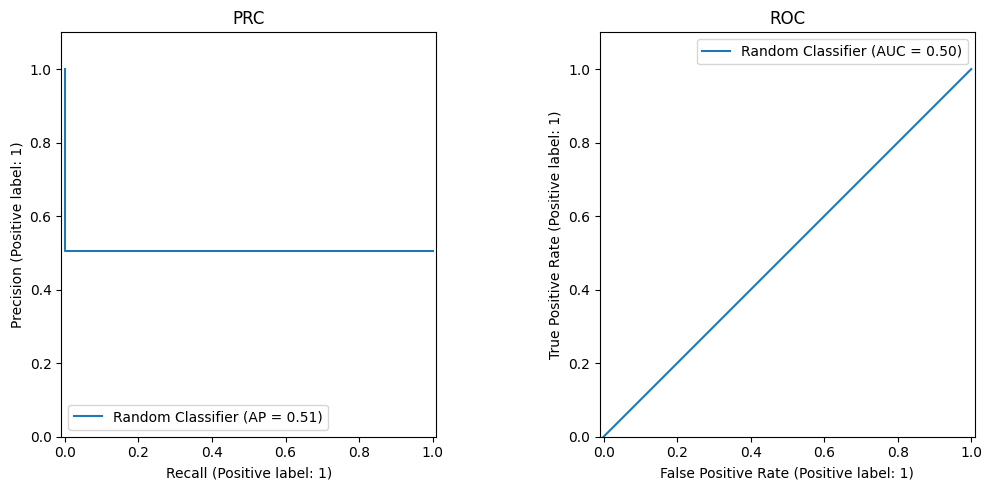

In [ ]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [ ]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LinearSVC(dual=False, max_iter=10000, random_state=42))
])


param_grid = {'svc__C': [0.01, 0.1, 1, 10, 100]}

scorer = make_scorer(average_precision_score, needs_proba=False)

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring=scorer,
    cv=5,
    verbose=1
)
grid_search.fit(X_train_sub, y_train_sub)


best_C = grid_search.best_params_['svc__C']
print(f"Лучший параметр C: {best_C}")

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Лучший параметр C: 0.01


Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.01, dual=False, max_iter=10000,
                           random_state=42))])

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

Linear SVM metrics
AUC-PR: 0.8299
AUC-ROC: 0.8476


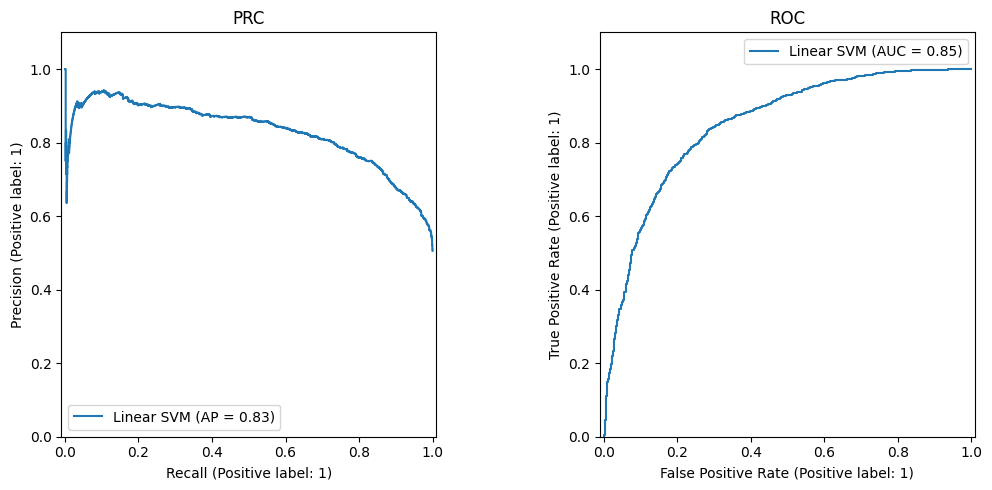

In [ ]:
y_scores = best_model.decision_function(X_test)


depict_pr_roc(y_test, y_scores, classifier_name="Linear SVM")

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

**Поведение кривых при увеличении порога**: При увеличении порога модель становится более строгой, включая в положительный класс только те объекты, по которым она максимально уверена. Это приводит к снижению Recall как в PR,то есть модель пропускает больше истинно положительных примеров. Precision в PR-кривой возрастает, поскольку среди отнесённых к положительному классу объектов становится меньше ложноположительных. На ROC-кривой при увеличении порога наблюдается уменьшение как истинно положительных (TPR), так и ложноположительных (FPR).


**Монотонность кривых**: ROC-кривая монотонна, поскольку TPR и FPR либо остаются неизменными, либо уменьшаются при увеличении порога. Это связано с тем, что модель постепенно исключает объекты из положительного класса. В PR-кривой видны небольшие колебания, что связано с тем, что Precision может снижаться при изменении соотношения истинно положительных и ложноположительных объектов.

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [ ]:
df_metrics.loc['Support Vector Machine'] = [
      average_precision_score(y_test, y_scores),
      roc_auc_score(y_test, y_scores),
      0,
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.50000,0.0
Support Vector Machine,0.829907,0.84758,0.0


Модель SVM  значительно лучше справляется с задачей классификации, чем случайный классификатор.

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [ ]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(penalty='l2', solver='liblinear', max_iter=10000, random_state=42))
])


param_grid = {'log_reg__C': np.logspace(-3, 2, 10)}

scorer = make_scorer(average_precision_score, needs_proba=True)


grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring=scorer,
    cv=5,
    verbose=1
)
grid_search.fit(X_train_sub, y_train_sub)


best_C = grid_search.best_params_['log_reg__C']
print(f"Лучший параметр C: {best_C}")

best_model_log = grid_search.best_estimator_
best_model_log.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучший параметр C: 0.003593813663804626


Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg',
                 LogisticRegression(C=0.003593813663804626, max_iter=10000,
                                    random_state=42, solver='liblinear'))])

Logistic regression metrics
AUC-PR: 0.8310
AUC-ROC: 0.8463


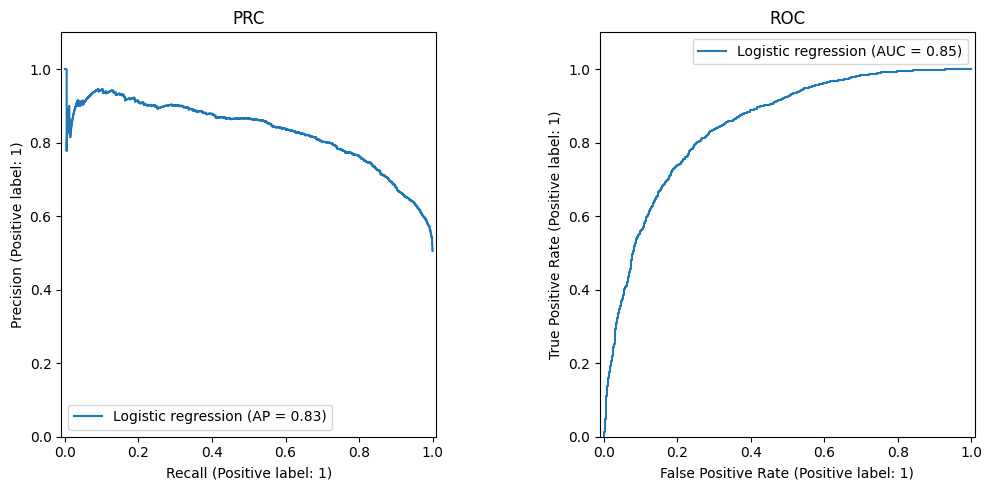

In [ ]:
y_scores_log = best_model_log.decision_function(X_test)


depict_pr_roc(y_test, y_scores_log, classifier_name="Logistic regression")

In [ ]:
df_metrics.loc['Logistic Regression'] = [
      average_precision_score(y_test, y_scores_log),
      roc_auc_score(y_test, y_scores_log),
      0,
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0
Support Vector Machine,0.829907,0.847580,0.0
Logistic Regression,0.830965,0.846319,0.0


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000
Linear SVM metrics
AUC-PR: 0.8299
AUC-ROC: 0.8476
Logistic Regression metrics
AUC-PR: 0.8310
AUC-ROC: 0.8463


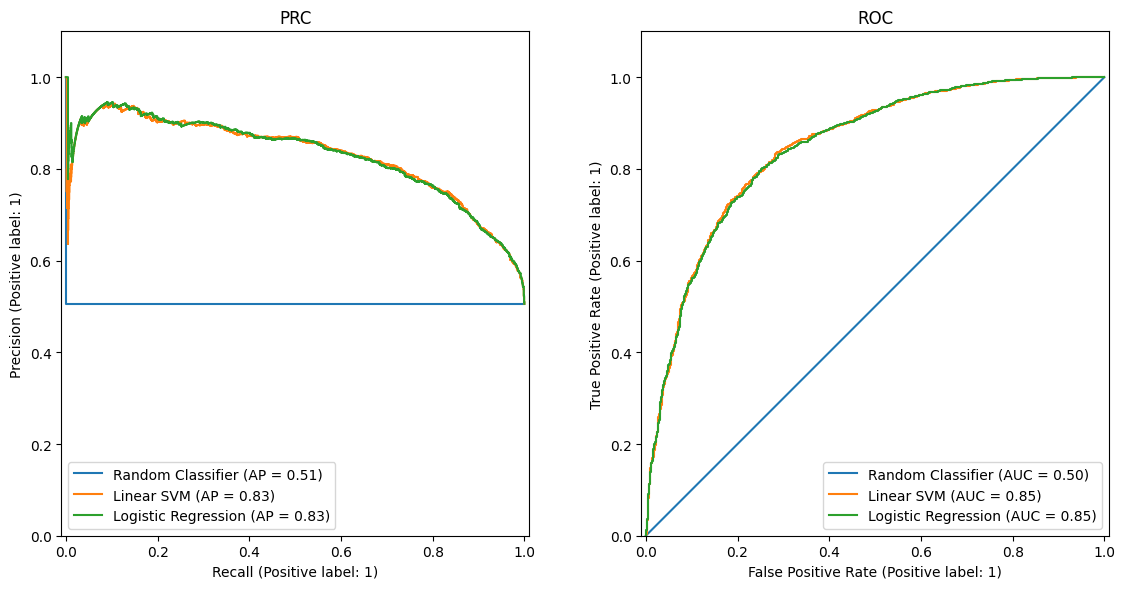

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

depict_pr_roc(y_test, y_random, classifier_name='Random Classifier', ax=ax)
depict_pr_roc(y_test, y_scores, classifier_name='Linear SVM', ax=ax)
depict_pr_roc(y_test, y_scores_log, classifier_name='Logistic Regression', ax=ax)

plt.show()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Сравнивая результаты логистической регрессии, метода опорных векторов и случайного классификатора, можно заметить существенное преимущество первых двух моделей. AUC-PR и AUC-ROC для случайного классификатора составляют 0.51 и 0.50 соответственно, что соответствует случайному угадыванию. В то же время, логистическая регрессия и SVM демонстрируют значительно более высокие значения метрик (AUC-PR ≈ 0.83, AUC-ROC ≈ 0.85), что подтверждает их способность эффективно различать классы. Между LR и SVM различия минимальны, хотя логистическая регрессия показывает чуть более высокую точность на PR-кривой, особенно при низких значениях полноты, благодаря особенностям минимизации логистической функции потерь. Таким образом, и SVM, и LR значительно превосходят случайный классификатор, с небольшим преимуществом LR в задачах, где важна точность при низкой полноте.



#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [ ]:
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
best_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.01, dual=False, max_iter=10000,
                           random_state=42))])

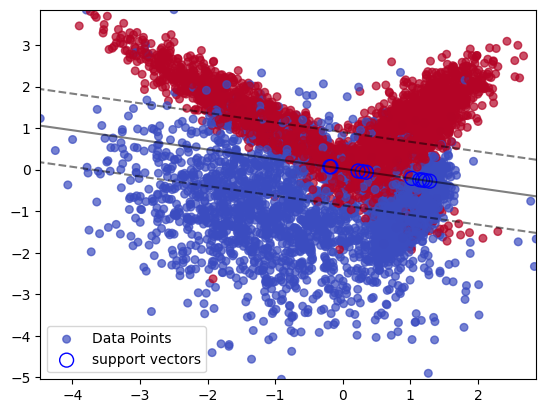

In [ ]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    svc_model = model.named_steps['svc']
    Z = svc_model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=30, label='Data Points', alpha=0.7)

    # Отрисовали опорные векторы
    if plot_support:
        distances = np.abs(svc_model.decision_function(X))
        support_indices = np.argsort(distances)[:10]
        plt.scatter(
            X[support_indices, 0],
            X[support_indices, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X_train, y_train, best_model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Объекты, выделенные как "опорные", — это те точки, которые находятся максимально близко к разделяющей гиперплоскости.



В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [ ]:
best_model_log.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg',
                 LogisticRegression(C=0.003593813663804626, max_iter=10000,
                                    random_state=42, solver='liblinear'))])

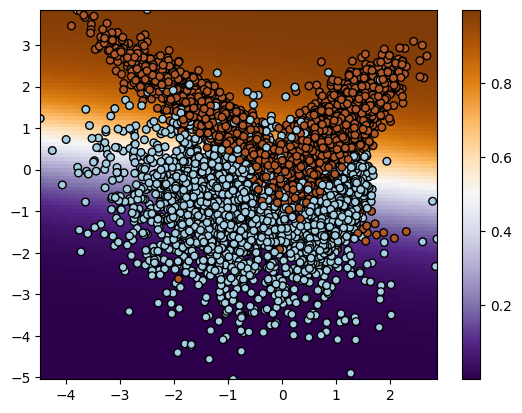

In [ ]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(
        X[:, 0], X[:, 1],
        c=y,
        edgecolor="k",
        cmap=plt.cm.Paired,
        s=30
    )

    plt.colorbar(image)

plot_logreg_2D(X_train, y_train, best_model_log)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** На картинке область, где модель не уверена визуализирована белым цветом. Это соответствует зоне, где вероятности классов максимально близки друг к другу, и модель не может с высокой уверенностью отнести объект к одному из классов. Теоретически, в логистической регрессии значение ($p(y=+1|x) = 0.5$)достигается, когда значение решающей функции равно нулю. Это означает, что эта область совпадает с разделяющей гиперплоскостью модели, которая делит пространство признаков на зоны, ассоциированные с каждым из классов.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [ ]:
def plot_calibration_curve(y_test, preds, label=None, color=None):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) # Ошибка 1. Вычисление середины отрезка как разности
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) # Ошибка 2. Доля единиц через min
    plt.plot(bin_middle_points, bin_real_ratios, marker='o', label=label, color=color)

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model_log.fit(X_train, y_train)
log_preds = best_model_log.predict_proba(X_test)[:, 1]

calibrated_svc = CalibratedClassifierCV(estimator=best_model.named_steps['svc'], cv="prefit")
calibrated_svc.fit(X_train, y_train)
svc_preds = calibrated_svc.predict_proba(X_test)[:, 1]

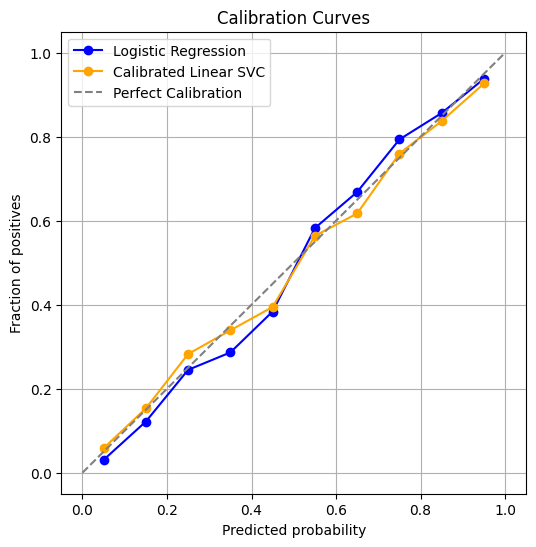

In [ ]:
plt.figure(figsize=(6, 6))

plot_calibration_curve(y_test, log_preds, label="Logistic Regression", color="blue")
plot_calibration_curve(y_test, svc_preds, label="Calibrated Linear SVC", color="orange")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect Calibration")
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])
plt.xlabel("Predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curves")
plt.legend()
plt.grid()
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** Кривые для обеих моделей откалиброваны достаточно хорошо, однако калибровочная кривая для SVM ближе к идеально откалиброванной диагонали, особенно в средней части диапазона вероятностей. Это говорит о том, что SVM точнее оценивает вероятности для большинства предсказаний. Логистическая регрессия демонстрирует немного большие отклонения, особенно в центральной части, что указывает на менее точную оценку вероятностей в этих интервалах.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [ ]:
from sklearn.metrics import log_loss, brier_score_loss

logloss_log = log_loss(y_test, log_preds)
logloss_svc = log_loss(y_test, svc_preds)

brier_log = brier_score_loss(y_test, log_preds)
brier_svc = brier_score_loss(y_test, svc_preds)

print(f"LogLoss (Logistic Regression): {logloss_log:.4f}")
print(f"LogLoss (SVM): {logloss_svc:.4f}")
print(f"BrierScore (Logistic Regression): {brier_log:.4f}")
print(f"BrierScore (SVM): {brier_svc:.4f}")

LogLoss (Logistic Regression): 0.4905
LogLoss (SVM): 0.4932
BrierScore (Logistic Regression): 0.1612
BrierScore (SVM): 0.1624


Результаты метрик LogLoss и BrierScore показывают, что логистическая регрессия лучше откалибрована, чем SVM. У логистической регрессии более низкие значения LogLoss и BrierScore, что указывает на меньшее отклонение предсказанных вероятностей от реальных значений.

Хотя визуально калибровочная кривая SVM выглядит ближе к диагонали на некоторых участках, формальные метрики говорят о том, что логистическая регрессия точнее оценивает вероятности на всём диапазоне.

Изучите распределение ответов классификаторов при помощи гистограмм

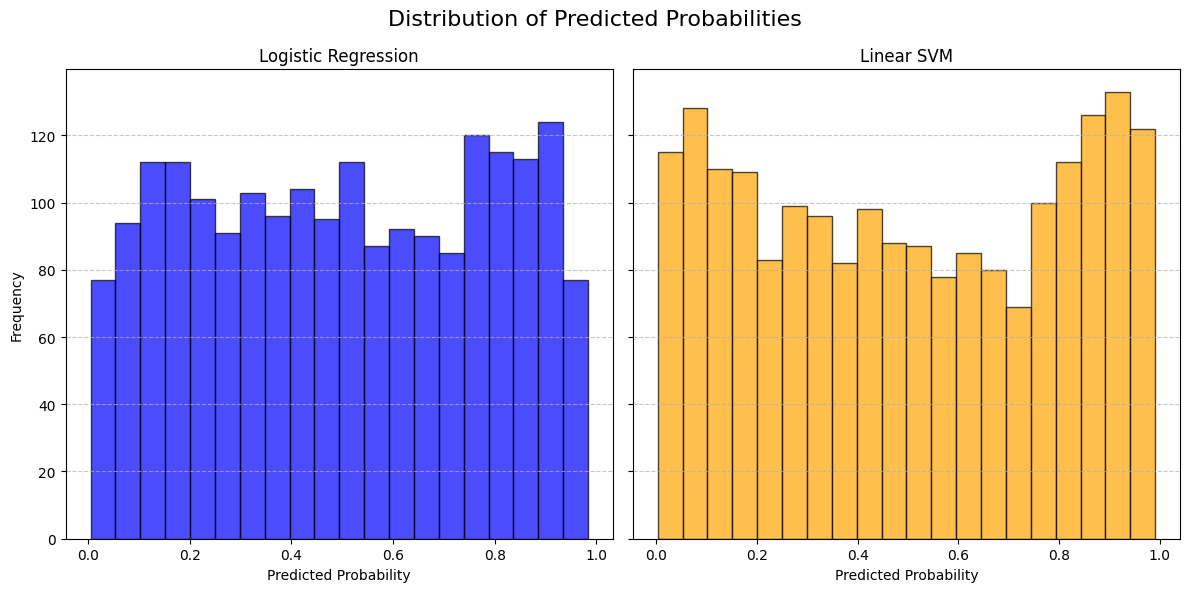

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axs[0].hist(log_preds, bins=20, color="blue", alpha=0.7, edgecolor='black')
axs[0].set_title("Logistic Regression")
axs[0].set_xlabel("Predicted Probability")
axs[0].set_ylabel("Frequency")
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

axs[1].hist(svc_preds, bins=20, color="orange", alpha=0.7, edgecolor='black')
axs[1].set_title("Linear SVM")
axs[1].set_xlabel("Predicted Probability")
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

fig.suptitle("Distribution of Predicted Probabilities", fontsize=16)
plt.tight_layout()
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Распределения предсказанных вероятностей для логистической регрессии и SVM имеют заметные различия.

Во-первых, предсказания логистической регрессии распределены относительно равномерно по всему диапазону вероятностей, что связано с тем, что логистическая регрессия оптимизирована для предоставления откалиброванных вероятностей напрямую, а не только для разделения классов. Во-вторых, распределение для SVM имеет пики около значений 0 и 1, что связано с тем, что SVM изначально не предназначен для предсказания вероятностей, а выдает значения, которые после калибровки могут концентрироваться ближе к границам.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [ ]:
calibrated_svc = CalibratedClassifierCV(estimator=best_model.named_steps['svc'], cv="prefit")
calibrated_svc.fit(X_train, y_train)

svc_calibrated_preds = calibrated_svc.predict_proba(X_test)[:, 1]

logloss_svc = log_loss(y_test, svc_preds)
brier_svc = brier_score_loss(y_test, svc_preds)
print(f"LogLoss (SVM): {logloss_svc:.4f}")
print(f"BrierScore (SVM): {brier_svc:.4f}")

LogLoss (SVM): 0.4932
BrierScore (SVM): 0.1624


**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Калибровочная кривая для метода опорных векторов, построенная после применения осталась идентичной той, что была до калибровки. Это говорит о том, что изначальная модель уже выдавала предсказания, которые хорошо интерпретировались как вероятности, и дополнительная калибровка не повлияла на качество предсказаний.

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
class PlattScaling:
    def __init__(self):
        self.model = LogisticRegression()

    def fit(self, scores, labels):
        scores = scores.reshape(-1, 1)
        self.model.fit(scores, labels)

    def predict(self, scores):
        scores = scores.reshape(-1, 1)
        return self.model.predict_proba(scores)[:, 1]

In [ ]:
best_model.fit(X_train, y_train)
svc_scores = best_model.decision_function(X_test)

platt = PlattScaling()
platt.fit(svc_scores, y_test)
calibrated_probs = platt.predict(svc_scores)

logloss_platt = log_loss(y_test, calibrated_probs)
brier_platt = brier_score_loss(y_test, calibrated_probs)
print(f"LogLoss (Platt Scaling): {logloss_platt:.4f}")
print(f"Brier Score (Platt Scaling): {brier_platt:.4f}")

LogLoss (Platt Scaling): 0.4881
Brier Score (Platt Scaling): 0.1601


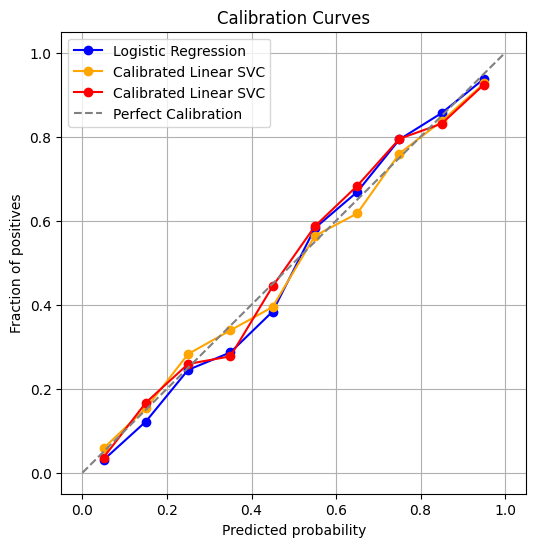

In [ ]:
plt.figure(figsize=(6, 6))

plot_calibration_curve(y_test, log_preds, label="Logistic Regression", color="blue")
plot_calibration_curve(y_test, svc_preds, label="Calibrated Linear SVC", color="orange")
plot_calibration_curve(y_test, calibrated_probs, label="Calibrated Linear SVC", color="red")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect Calibration")
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])
plt.xlabel("Predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curves")
plt.legend()
plt.grid()
plt.show()

Применение Platt Scaling показало улучшение качества калибровки вероятностей для метода опорных векторов. Это видно из снижения значений метрик: LogLoss уменьшился до 0.4881, а Brier Score составил 0.1601, что лучше показателей некалиброванной модели. Эти результаты говорят о том, что предсказанные вероятности стали лучше отражать истинную частоту классов.

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [ ]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [ ]:
# Прочитаем датасет
data_bike = pd.read_csv(path)

# Заменим пропуски категориальных переменных
categorical_columns = data_bike.select_dtypes(include=['object', 'category']).columns
data_bike[categorical_columns] = data_bike[categorical_columns].fillna('undefined')

# Отделим X и y
y = data_bike.iloc[:, -1]
X = data_bike.iloc[:, :-1]

# Разделим на категориальные признаки и числовые
X_numerical = X.select_dtypes(include=['int64', 'float64'])
X_categorical = X.select_dtypes(include=['object', 'category'])

В начале поработаем только с категориальными признаками

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
import time

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

X_train_ordinal = X_train.copy()
X_test_ordinal = X_test.copy()

encoder = OrdinalEncoder()

start_time = time.time()

X_train_ordinal[X_train_ordinal.select_dtypes(include=['object', 'category']).columns] = encoder.fit_transform(X_train_ordinal[X_train_ordinal.select_dtypes(include=['object', 'category']).columns])
X_test_ordinal[X_test_ordinal.select_dtypes(include=['object', 'category']).columns] = encoder.transform(X_test_ordinal[X_test_ordinal.select_dtypes(include=['object', 'category']).columns])

logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train_ordinal, y_train)

training_time = time.time() - start_time

y_pred = logistic_model.predict_proba(X_test_ordinal)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

print(f"AUC-PR: {auc_pr:.4f}")
print(f"Время обучения модели с кодированием признаков: {training_time:.2f} секунд")

AUC-PR: 0.5887
Время обучения модели с кодированием признаков: 0.06 секунд


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X_train_ohe = X_train.copy()
X_test_ohe = X_test.copy()

categorical_columns = X_train_ohe.select_dtypes(include=['object', 'category']).columns.tolist()
one_hot_encoder = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)],
    remainder='passthrough'
)

start_time = time.time()

X_train_ohe = one_hot_encoder.fit_transform(X_train_ohe)
X_test_ohe = one_hot_encoder.transform(X_test_ohe)

logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train_ohe, y_train)

training_time = time.time() - start_time


y_pred = logistic_model.predict_proba(X_test_ohe)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

print(f"AUC-PR: {auc_pr:.4f}")
print(f"Время обучения модели с кодированием признаков: {training_time:.2f} секунд")

AUC-PR: 0.6663
Время обучения модели с кодированием признаков: 0.03 секунд


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [ ]:
def mean_target_encoding(X_train, X_test, y, column):
    means = X_train.groupby(column).apply(lambda x: y[x.index].mean())
    train_encoded = X_train[column].map(means)
    test_encoded = X_test[column].map(means).fillna(means.mean())
    return train_encoded, test_encoded

X_train_mte = X_train.copy()
X_test_mte = X_test.copy()

start_time = time.time()

y_train = pd.Series(y_train, index=X_train.index)
for column in categorical_columns:
    X_train_mte[column], X_test_mte[column] = mean_target_encoding(
        X_train_mte, X_test_mte, y_train, column
    )

logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train_mte, y_train)


training_time = time.time() - start_time

y_pred = logistic_model.predict_proba(X_test_mte)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

print(f"AUC-PR: {auc_pr:.4f}")
print(f"Время обучения модели с кодированием признаков (mean-target encoding): {training_time:.2f} секунд")

AUC-PR: 0.6575
Время обучения модели с кодированием признаков (mean-target encoding): 0.07 секунд


<ipython-input-39-51a8d8cd3901>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  means = X_train.groupby(column).apply(lambda x: y[x.index].mean())
<ipython-input-39-51a8d8cd3901>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  means = X_train.groupby(column).apply(lambda x: y[x.index].mean())
<ipython-input-39-51a8d8cd3901>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. Th

One-hot encoding показал лучший результат (AUC-PR = 0.6663) и оказался самым быстрым (0.03 секунд). Mean-target encoding тоже дал хороший результат (AUC-PR = 0.6575), но занял чуть больше времени (0.07 секунд) и подходит для задач с большим количеством категорий, так как не увеличивает число признаков. Ordinal encoding оказался самым слабым (AUC-PR = 0.5887), потому что добавляет порядок там, где его нет, но он всё равно быстро работает (0.06 секунд).

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features):

        self.categorical_features = categorical_features
        self.statistics_ = {}

    def fit(self, X, y):

        for feature in self.categorical_features:
            self.statistics_[feature] = X[feature].map(
                X.groupby(feature).apply(lambda x: y[x.index].mean())
            )

        return self

    def transform(self, X):

        for feature in self.categorical_features:
            if feature in self.statistics_:
                X[feature] = X[feature].map(self.statistics_[feature]).fillna(0)

        return X

In [ ]:
X_train_mte_soph = X_train.copy()
X_test_mte_soph = X_test.copy()

encoder = MeanTargetEncoder(categorical_columns)

X_train_encoded = encoder.fit_transform(X_train_mte_soph, y_train)
X_test_encoded = encoder.transform(X_test_mte_soph)

logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train_encoded, y_train)

y_pred = logistic_model.predict_proba(X_test_encoded)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

print(f"AUC-PR: {auc_pr:.4f}")

AUC-PR: 0.4800


<ipython-input-40-73cd03b725a1>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X.groupby(feature).apply(lambda x: y[x.index].mean())
<ipython-input-40-73cd03b725a1>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X.groupby(feature).apply(lambda x: y[x.index].mean())
<ipython-input-40-73cd03b725a1>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecat

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [47]:
class MeanTargetEncoderWithNoise(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, alpha=5, noise_level=0.01, random_state=None):

        self.categorical_features = categorical_features
        self.alpha = alpha
        self.noise_level = noise_level
        self.random_state = random_state
        self.statistics_ = {}

    def _add_noise(self, series):

        rng = np.random.default_rng(self.random_state)
        return series * (1 + rng.normal(0, self.noise_level, size=series.shape))

    def fit(self, X, y):

        for feature in self.categorical_features:
            mean_y = y.mean()
            stats = X.groupby(feature).apply(lambda x: (y[x.index].sum() + self.alpha * mean_y) /
                                              (len(x) + self.alpha))
            self.statistics_[feature] = stats
        return self

    def transform(self, X):

        for feature in self.categorical_features:
            if feature in self.statistics_:
                encoded = X[feature].map(self.statistics_[feature]).fillna(0)
                X[feature] = self._add_noise(encoded)
        return X

In [ ]:
X_train_mte_noise = X_train.copy()
X_test_mte_noise = X_test.copy()

encoder_with_noise = MeanTargetEncoderWithNoise(
    categorical_columns, alpha=5, noise_level=0.05, random_state=42
)

X_train_mte_noise = encoder_with_noise.fit_transform(X_train_mte_noise, y_train)
X_test_mte_noise = encoder_with_noise.transform(X_test_mte_noise)


model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_mte_noise, y_train)


y_pred = model.predict_proba(X_test_mte_noise)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

print(f"AUC-PR: {auc_pr:.4f}")

AUC-PR: 0.6280


<ipython-input-44-4a2892a9c632>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats = X.groupby(feature).apply(lambda x: (y[x.index].sum() + self.alpha * mean_y) /
<ipython-input-44-4a2892a9c632>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats = X.groupby(feature).apply(lambda x: (y[x.index].sum() + self.alpha * mean_y) /
<ipython-input-44-4a2892a9c632>:19: DeprecationWarning: DataFrameGroupBy.a

**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Добавление шума к значениям счётчиков значительно улучшило метрику AUC-PR. Это связано с тем, что шум снижает риск переобучения модели на категориальных признаках, особенно если в данных присутствуют редкие категории. Без шума модель могла запомнить точные средние значения целевой переменной для каждой категории в обучающей выборке, что ухудшало обобщающую способность на тестовых данных. С добавлением случайного шума модель становится менее чувствительной к конкретным значениям средних, что позволяет лучше адаптироваться к новым данным и сохранять полезность признаков.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
from sklearn.model_selection import KFold
class FoldMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, n_folds=5, noise_level=0.01, random_state=None):
        self.categorical_features = categorical_features
        self.n_folds = n_folds
        self.noise_level = noise_level
        self.random_state = random_state

    def _add_noise(self, series):
        rng = np.random.default_rng(self.random_state)
        return series * (1 + rng.normal(0, self.noise_level, size=series.shape))

    def fit(self, X, y):
        self.statistics_ = {}
        X = X.copy().reset_index(drop=True)
        y = y.copy().reset_index(drop=True)
        y.name = 'target'
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)

        for feature in self.categorical_features:
            X[feature + '_encoded'] = np.nan

            for train_idx, val_idx in kf.split(X):
                X_train= X.iloc[train_idx].copy()
                X_val = X.iloc[val_idx].copy()
                train_y = y.iloc[train_idx].reset_index(drop=True)

                X_train['target'] = train_y

                means = X_train.groupby(feature)['target'].mean()

                val_encoded = X_val[feature].map(means)

                X.iloc[val_idx, X.columns.get_loc(feature + '_encoded')] = val_encoded.values

            self.statistics_[feature] = X.groupby(feature)[feature + '_encoded'].mean()

        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.categorical_features:
            if feature in self.statistics_:
                encoded_feature = X_transformed[feature].map(self.statistics_[feature]).fillna(0)
                X_transformed[feature + '_encoded'] = self._add_noise(encoded_feature)
                X_transformed.drop(columns=feature, inplace=True)
        return X_transformed

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

In [ ]:
X_train_mte_kfolds = X_train.copy()
X_test_mte_kfolds = X_test.copy()

encoder = FoldMeanTargetEncoder(
    categorical_columns, n_folds=3, noise_level=0.05, random_state=42
    )

X_train_mte_kfolds = encoder.fit_transform(X_train_mte_kfolds, y_train)
X_test_mte_kfolds = encoder.transform(X_test_mte_kfolds)

logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train_mte_kfolds, y_train)

y_pred = logistic_model.predict_proba(X_test_mte_kfolds)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

print(f"AUC-PR: {auc_pr:.4f}")

AUC-PR: 0.5952


#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [ ]:
class SmoothedMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, n_folds=5, noise_level=0.01, C=10, random_state=None):

        self.categorical_features = categorical_features
        self.n_folds = n_folds
        self.noise_level = noise_level
        self.C = C
        self.random_state = random_state
        self.statistics_ = {}

    def _add_noise(self, series):
        rng = np.random.default_rng(self.random_state)
        return series * (1 + rng.normal(0, self.noise_level, size=series.shape))

    def fit(self, X, y):

        X = X.copy()
        y = pd.Series(y, index=X.index)
        X.reset_index(drop=True, inplace=True)
        y.reset_index(drop=True, inplace=True)
        y.name = 'target'
        self.global_mean = y.mean()

        Xy = X.copy()
        Xy['target'] = y

        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)

        for feature in self.categorical_features:

            Xy[feature + '_encoded'] = np.nan

            for train_idx, val_idx in kf.split(Xy):

                train_data = Xy.iloc[train_idx].copy()
                val_data = Xy.iloc[val_idx].copy()

                category_counts = train_data.groupby(feature).size()
                category_sums = train_data.groupby(feature)['target'].sum()

                smoothed_means = (category_sums + self.C * self.global_mean) / (category_counts + self.C)

                val_encoded = val_data[feature].map(smoothed_means)

                Xy.iloc[val_idx, Xy.columns.get_loc(feature + '_encoded')] = val_encoded.values

            category_counts = Xy.groupby(feature).size()
            category_sums = Xy.groupby(feature)['target'].sum()

            self.statistics_[feature] = (category_sums + self.C * self.global_mean) / (category_counts + self.C)

        return self

    def transform(self, X):
        X = X.copy()

        for feature in self.categorical_features:
            if feature in self.statistics_:

                X[feature + '_encoded'] = X[feature].map(self.statistics_[feature]).fillna(self.global_mean)
                X[feature + '_encoded'] = self._add_noise(X[feature + '_encoded'])
                X.drop(columns=feature, inplace=True)

        return X


In [ ]:
from sklearn.model_selection import StratifiedKFold

param_grid = {
    'encoder__C': [0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 5, 10]
}


pipeline = Pipeline([
    ('encoder', SmoothedMeanTargetEncoder(
        categorical_features=categorical_columns,
        n_folds=5,
        noise_level=0.05,
        random_state=42
    )),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='average_precision',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    error_score='raise'
)

grid_search.fit(X_train, y_train)

best_c = grid_search.best_params_['encoder__C']
best_score = grid_search.best_score_

print(f"Best value of C: {best_c}")
print(f"Best AUC-PR on validation: {best_score:.4f}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best value of C: 0.8
Best AUC-PR on validation: 0.5768


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [ ]:
def detect_outliers_in_numerical(df_numerical):

    outliers_info = []

    for column in df_numerical.columns:
        Q1 = df_numerical[column].quantile(0.25)
        Q3 = df_numerical[column].quantile(0.75)
        IQR = Q3 - Q1


        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df_numerical[(df_numerical[column] < lower_bound) | (df_numerical[column] > upper_bound)]
        outliers_count = len(outliers)


        outliers_info.append({
            'Feature': column,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Outliers Count': outliers_count,
            'Percentage': (outliers_count / len(df_numerical)) * 100
        })

    return pd.DataFrame(outliers_info)


outliers_summary = detect_outliers_in_numerical(X_numerical)
outliers_summary

,Feature,Lower Bound,Upper Bound,Outliers Count,Percentage
0,ID,1520.75,38240.75,0,0.0
1,Income,-30000.00,130000.00,10,1.0
2,Children,-4.50,7.50,0,0.0
3,Cars,-0.50,3.50,59,5.9
4,Age,9.50,77.50,4,0.4


In [ ]:
X_numerical['Income'] = X_numerical['Income'].fillna(X_numerical['Income'].median())
X_numerical['Cars'] = X_numerical['Cars'].fillna(X_numerical['Cars'].median())
X_numerical['Age'] = X_numerical['Age'].fillna(X_numerical['Age'].median())
X_numerical['Children'] = X_numerical['Children'].fillna(X_numerical['Children'].mean())

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [ ]:
from scipy.sparse import hstack

X_train_numerical, X_test_numerical = train_test_split(X_numerical, test_size=0.25, random_state=777, stratify=y)

numerical_encoder = FoldMeanTargetEncoder(
    categorical_features=['Income', 'Children', 'Cars', 'Age'],
    n_folds=5,
    noise_level=0.05,
    random_state=42
)
X_train_numerical = numerical_encoder.fit_transform(X_train_numerical, y_train)
X_test_numerical = numerical_encoder.transform(X_test_numerical)

X_train_combined = np.hstack([X_train_mte_kfolds, X_train_numerical])
X_test_combined = np.hstack([X_test_mte_kfolds, X_test_numerical])
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_combined, y_train)

y_pred = model.predict_proba(X_test_combined)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

print(f"AUC-ROC: {auc_pr:.4f}")

AUC-ROC: 0.5527


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Счётчики позволяют значительно сократить размерность данных, что особенно важно при большом количестве категорий. Это снижает вычислительную нагрузку. Счётчики также учитывают связь категорий с целевой переменной, что может улучшить качество предсказаний, особенно для линейных моделей.

 Использование счетчиков требует аккуратного расчёта, чтобы избежать утечки данных между обучающей и тестовой выборками. Также они менее устойчивы к дисбалансу классов и шуму в данных, что может снизить их эффективность.
  

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [16]:
from sklearn.metrics import average_precision_score

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-11-29 06:59:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [   <=>              ]   3.79M  7.60MB/s    in 0.5s    

2024-11-29 06:59:49 (7.60 MB/s) - ‘adult.data’ saved [3974305]



In [4]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
30793,20,Private,334105,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,10,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [7]:
y = df.iloc[:, -1]
X = df.iloc[:, :-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [12]:
categorical= df.select_dtypes(include=['object', 'category']).columns
numeric = df.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical)
    ],
    remainder='passthrough'
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
print(f"Количество столбцов после кодирования методом OHE: {X_train_transformed.shape[1]}")

Количество столбцов после кодирования методом OHE: 108


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [17]:
logistic_model = LogisticRegression(max_iter=3000, random_state=42)
logistic_model.fit(X_train_transformed, y_train)

y_pred = logistic_model.predict_proba(X_test_transformed)[:, 1]
auc_pr_sim = average_precision_score(y_test, y_pred)

print(f"AUC-PR: {auc_pr_sim:.4f}")

AUC-PR: 0.7493


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [18]:
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_transformed, y_train, test_size=0.2, random_state=777)

In [19]:
X_train_final

array([[ 0.,  0.,  0., ...,  0.,  0., 30.],
       [ 0.,  0.,  0., ...,  0.,  0., 55.],
       [ 1.,  0.,  0., ...,  0.,  0., 40.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0., 16.],
       [ 0.,  0.,  0., ...,  0.,  0., 45.],
       [ 0.,  0.,  0., ...,  0.,  0., 37.]])

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [20]:
import time

In [21]:
start_time = time.time()

coefficients = np.abs(logistic_model.coef_)[0]
top_40 = np.argsort(coefficients)[-40:]

selection_time = time.time() - start_time

X_train_reduced = X_train_final[:, top_40]
X_val_reduced = X_val[:, top_40]

logistic_model_reduced = LogisticRegression(max_iter=1000, random_state=42)
logistic_model_reduced.fit(X_train_reduced, y_train_final)

y_pred = logistic_model_reduced.predict_proba(X_val_reduced)[:, 1]
auc_pr = average_precision_score(y_val, y_pred)

print(f"Время на отбор признаков: {selection_time:.4f} секунд")
print(f"AUC-PR на 40 признаках: {auc_pr:.4f}")

Время на отбор признаков: 0.0002 секунд
AUC-PR на 40 признаках: 0.6958


Изменилось ли качество? Как?

Качество модели ухудшилось, скорее всего, из-за потери значимой информации при удалении некоторых признаков, которые могли быть важны в комбинации с другими. Логистическая регрессия обрабатывает каждый признак линейно, поэтому взаимодействия между ними не учитываются. Отбор по коэффициентам модели не всегда отражает их реальную полезность, особенно если данные шумные или признаки слабо выражены.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [23]:
logistic_model_full = LogisticRegression(max_iter=1000, random_state=42)
logistic_model_full.fit(X_train_final, y_train_final)

y_pred = logistic_model_full.predict_proba(X_val)[:, 1]
auc_pr = average_precision_score(y_val, y_pred)

print(f"AUC-PR на всех признаках: {auc_pr:.4f}")

AUC-PR на всех признаках: 0.7348


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Качество модели на полном наборе признаков заметно улучшилось, что можно объяснить потерей значимых зависимостей с целевой переменной при исключении некоторых признаков из модели.

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [30]:
from sklearn.preprocessing import StandardScaler
preprocessor = StandardScaler()
X_train_transformed = preprocessor.fit_transform(X_train_final)
X_val_transformed = preprocessor.transform(X_val)


start_time = time.time()

logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train_transformed, y_train_final)

coefficients = np.abs(logistic_model.coef_)[0]
top_40_norm = np.argsort(coefficients)[-40:]

selection_time = time.time() - start_time

X_train_reduced = X_train_transformed[:, top_40]
X_val_reduced = X_val_transformed[:, top_40]

logistic_model_reduced = LogisticRegression(max_iter=1000, random_state=42)
logistic_model_reduced.fit(X_train_reduced, y_train_final)

y_pred = logistic_model_reduced.predict_proba(X_val_reduced)[:, 1]
auc_pr = average_precision_score(y_val, y_pred)

print(f"Время на отбор признаков: {selection_time:.4f} секунд")
print(f"AUC-PR на 40 признаках после скалирования: {auc_pr:.4f}")

print(f"Совпадают ли топ-40 признаков после и до скалирования? {'Да' if set(top_40_norm) == set(top_40) else 'Нет'}")

Время на отбор признаков: 0.3327 секунд
AUC-PR на 40 признаках после скалирования: 0.6954
Совпадают ли топ-40 признаков после и до скалирования? Нет


Топ-40 признаков изменился после скалирования, а качество модели снизилось. Вероятно, это связано с тем, что признаки с высокой дисперсией оказывали значительное влияние на модель, и их вклад был нивелирован в результате скалирования. Кроме того, снижение качества могло быть вызвано скалированием бинарных признаков, что могло исказить их влияние в модели.

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** Чем выше корреляция между признаком и целевой переменной, тем сильнее влияние этого признака на предсказание значений целевой переменной. Я бы ввела порог для отсечения признаков с низкой корреляцией, что позволяет исключить те признаки, которые оказывают незначительное влияние на целевую переменную.

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [35]:
correlations = np.array([np.corrcoef(X_train_final[:, i], y_train_final)[0, 1] for i in range(X_train_final.shape[1])])
filtered_indices = np.where(np.abs(correlations) >= 0.2)[0]

start_time = time.time()

top_40 = filtered_indices[np.argsort(np.abs(correlations[filtered_indices]))[-40:]]

X_train_reduced = X_train_final[:, top_40]
X_val_reduced = X_val[:, top_40]

selection_time = time.time() - start_time

logistic_model_reduced = LogisticRegression(max_iter=1000, random_state=42)
logistic_model_reduced.fit(X_train_reduced, y_train_final)

y_pred = logistic_model_reduced.predict_proba(X_val_reduced)[:, 1]
auc_pr_filter = average_precision_score(y_val, y_pred)

selection_time = time.time() - start_time

print(f"Время на отбор признаков: {selection_time:.4f} секунд")
print(f"AUC-PR на 40 признаках фильтрующей обработкой: {auc_pr_filter:.4f}")

Время на отбор признаков: 4.6536 секунд
AUC-PR на 40 признаках фильтрующей обработкой: 0.7455


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [36]:
X_positive = X_train_final[y_train_final == 1]
X_negative = X_train_final[y_train_final == 0]

n_positive = X_positive.shape[0]
n_negative = X_negative.shape[0]

t_statistics = []

for j in range(X_train_final.shape[1]):
    mu_positive = np.mean(X_positive[:, j])
    mu_negative = np.mean(X_negative[:, j])
    sigma_positive = np.var(X_positive[:, j])
    sigma_negative = np.var(X_negative[:, j])

    t_j = np.abs(mu_positive - mu_negative) / np.sqrt(
        (n_positive * sigma_positive + n_negative * sigma_negative) / (n_positive + n_negative)
    )
    t_statistics.append(t_j)

t_statistics = np.array(t_statistics)

start_time = time.time()

top_40_indices = np.argsort(t_statistics)[-40:]

X_train_reduced = X_train_final[:, top_40]
X_val_reduced = X_val[:, top_40]

selection_time = time.time() - start_time

logistic_model_reduced = LogisticRegression(max_iter=1000, random_state=42)
logistic_model_reduced.fit(X_train_reduced, y_train_final)

y_pred = logistic_model_reduced.predict_proba(X_val_reduced)[:, 1]
auc_pr_filter = average_precision_score(y_val, y_pred)

selection_time = time.time() - start_time

print(f"Время на отбор признаков: {selection_time:.4f} секунд")
print(f"AUC-PR на 40 признаках c использованием t-статистики: {auc_pr_filter:.4f}")

Время на отбор признаков: 3.9155 секунд
AUC-PR на 40 признаках c использованием t-статистики: 0.7455


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

https://arismuhandisin.medium.com/understanding-wrapper-methods-in-machine-learning-a-guide-to-feature-selection-23f71059abf8

In [37]:
num_features_to_select = 40
err_lr = 0.001
lrs = [1, 5, 10, 20]

best_step = None
best_auc = -1
start_time = time.time()

for step in lrs:
    current_features = list(range(X_train_final.shape[1]))
    while len(current_features) > num_features_to_select:

        X_train_reduced = X_train_final[:, current_features]
        X_val_reduced = X_val[:, current_features]

        logistic_model = LogisticRegression(max_iter=1000, random_state=42)
        logistic_model.fit(X_train_reduced, y_train_final)

        y_pred = logistic_model.predict_proba(X_val_reduced)[:, 1]
        current_auc = average_precision_score(y_val, y_pred)

        t_statistics = []
        for feature_idx in current_features:
            X_positive = X_train_final[y_train_final == 1][:, feature_idx]
            X_negative = X_train_final[y_train_final == 0][:, feature_idx]

            mu_positive = np.mean(X_positive)
            mu_negative = np.mean(X_negative)
            sigma_positive = np.var(X_positive)
            sigma_negative = np.var(X_negative)

            t_j = np.abs(mu_positive - mu_negative) / np.sqrt(
                (len(X_positive) * sigma_positive + len(X_negative) * sigma_negative) / len(y_train_final)
            )
            t_statistics.append(t_j)

        t_statistics = np.array(t_statistics)

        num_to_remove = min(len(current_features) - num_features_to_select, step)
        least_important_indices = np.argsort(t_statistics)[:num_to_remove]
        current_features = [f for i, f in enumerate(current_features) if i not in least_important_indices]

    X_train_final_reduced = X_train_final[:, current_features]
    X_val_final_reduced = X_val[:, current_features]

    logistic_model_final = LogisticRegression(max_iter=1000, random_state=42)
    logistic_model_final.fit(X_train_final_reduced, y_train_final)

    y_pred_final = logistic_model_final.predict_proba(X_val_final_reduced)[:, 1]
    final_auc = average_precision_score(y_val, y_pred_final)


    if final_auc > best_auc:
        best_auc = final_auc
        best_step = step


selection_time = time.time() - start_time


print(f"Оптимальная длина начального шага: {best_step}")
print(f"Время работы алгоритма: {selection_time:.4f} секунд")
print(f"AUC-PR на тестовой выборке: {final_auc:.4f}")
print(f"Число отобранных признаков: {len(current_features)}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Оптимальная длина начального шага: 1
Время работы алгоритма: 468.2996 секунд
AUC-PR на тестовой выборке: 0.7606
Число отобранных признаков: 40


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [38]:
num_features_to_select = 40
selected_features = []
best_auc = -1

start_time = time.time()


while len(selected_features) < num_features_to_select:
    best_feature = None
    current_best_auc = -1

    for feature_idx in range(X_train_final.shape[1]):
        if feature_idx in selected_features:
            continue


        candidate_features = selected_features + [feature_idx]


        X_train_reduced = X_train_final[:, candidate_features]
        X_val_reduced = X_val[:, candidate_features]

        logistic_model = LogisticRegression(max_iter=1000, random_state=42)
        logistic_model.fit(X_train_reduced, y_train_final)


        y_pred = logistic_model.predict_proba(X_val_reduced)[:, 1]
        current_auc = average_precision_score(y_val, y_pred)


        if current_auc > current_best_auc:
            current_best_auc = current_auc
            best_feature = feature_idx


    if current_best_auc <= best_auc:
        break


    selected_features.append(best_feature)
    best_auc = current_best_auc


X_train_final_reduced = X_train_final[:, selected_features]
X_val_final_reduced = X_val[:, selected_features]

logistic_model_final = LogisticRegression(max_iter=1000, random_state=42)
logistic_model_final.fit(X_train_final_reduced, y_train_final)

y_pred_final = logistic_model_final.predict_proba(X_val_final_reduced)[:, 1]
final_auc = average_precision_score(y_val, y_pred_final)

selection_time = time.time() - start_time


print(f"\nВремя работы алгоритма: {selection_time:.4f} секунд")
print(f"AUC-PR на тестовой выборке: {final_auc:.4f}")
print(f"Число отобранных признаков: {len(selected_features)}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Время работы алгоритма: 1184.3922 секунд
AUC-PR на тестовой выборке: 0.7645
Число отобранных признаков: 11


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Встроенные методы отбора признаков имеют такие преимущества, как простота реализации и удобная интеграция в процесс обучения модели. Однако их основной недостаток заключается в том, что они не учитывают нелинейные связи между признаками и целевой переменной, что может приводить к исключению признаков, которые оказываются полезными только в сочетании с другими. Кроме того, такие методы склонны исключать признаки слабо выраженной связью с целевой переменной, даже если эти признаки содержат важную информацию. Ещё одним ограничением встроенных методов является предположение, что признаки вносят вклад в предсказание целевой переменной равномерно, что не соответствует особенностям реальных данных, где влияние признаков может значительно варьироваться.

Методы фильтрации показывают более качественные результаты, так как они оценивают взаимосвязь между признаками и целевой переменной, что позволяет лучше выделять важные признаки. Однако они оценивают признаки изолированно, без учёта их взаимодействия между собой. Тем не менее, этот подход обеспечивает более устойчивые результаты по сравнению со встроенными методами, особенно на начальном этапе анализа данных.

Методы-обёртки демонстрируют ещё более высокую эффективность, так как их алгоритм адаптируется под конкретный набор данных. Они позволяют учитывать взаимодействия между признаками и фокусируются на улучшении качества модели в рамках заданной задачи. Однако методы-обёртки требуют значительных вычислительных ресурсов и времени, особенно при большом количестве признаков.

Наилучший результат в данном исследовании показал метод оберток в обратную сторону.

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [39]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2024-11-29 10:03:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [  <=>               ] 434.15K  1.39MB/s    in 0.3s    

2024-11-29 10:03:21 (1.39 MB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [40]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [41]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [90]:
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

def cross_validate(#model,
    X,
    y,
    n_splits=5,
    random_state=42,
    shuffle=True,
    C=0.1,
    thresholds=np.arange(0, 1.01, 0.01)
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    profits_by_threshold = {threshold: [] for threshold in thresholds}
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = preprocessor.fit_transform(X_train)
        X_test = preprocessor.transform(X_test)

        model = LogisticRegression(max_iter=1000, random_state=random_state, C=C)
        model.fit(X_train, y_train)

        #y_pred = model.predict(X_test)-для первого и второго задания
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        best_profit = -float("inf")
        best_threshold = None

        for threshold in thresholds:

            y_pred = (y_pred_proba >= threshold).astype(int)

            calls_made = sum(y_pred == 1)
            successful_calls = sum((y_pred == 1) & (y_test == 1))
            #profit = (10 * successful_calls) - (2 * calls_made) - для первого варианта
            revenue = sum(np.random.uniform(0, 20, size=successful_calls))
            profit = revenue  - (2 * calls_made)
            profits_by_threshold[threshold].append(profit)

            if profit > best_profit:
                best_profit = profit
                best_threshold = threshold

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        y_pred_best = (y_pred_proba >= best_threshold).astype(int)
        #metric_dict = { для первого и второго задания
           # "accuracy": accuracy_score(y_test, y_pred),
           # "roc_auc": roc_auc_score(y_test, y_pred_proba),
           # "f1": f1_score(y_test, y_pred),
           # "auc_pr": average_precision_score(y_test, y_pred_proba),
           # "profit": profit,
           # "calls_made": calls_made
        #}
        metric_dict = {
            "accuracy": accuracy_score(y_test, y_pred_best),
            "roc_auc": roc_auc_score(y_test, y_pred_proba),
            "f1": f1_score(y_test, y_pred_best),
            "auc_pr": average_precision_score(y_test, y_pred_proba),
            "profit": best_profit,
            "best_threshold": best_threshold
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics), profits_by_threshold

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [53]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

numeric = X.select_dtypes(include=['float', 'int']).columns.tolist()
binary = [col for col in numeric if X[col].nunique() == 2]
numeric = [col for col in numeric if col not in binary]
categorical = X.select_dtypes(include=['object']).columns.tolist()


numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler(with_mean=False))
])



binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric),
        ('cat', categorical_transformer, categorical),
        ('binary', binary_transformer, binary)
    ]
)

In [60]:
model = LogisticRegression(max_iter=1000, random_state=42)

cv_results = cross_validate(model, X, y, n_splits=5)

print("Средние метрики по фолдам:")
cv_results.mean()

Средние метрики по фолдам:


,0
accuracy,0.900311
roc_auc,0.791298
f1,0.339579
auc_pr,0.450518


In [63]:
best_auc_pr = cv_results['auc_pr'].mean()

Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [69]:
cv_results = cross_validate(model, X, y, n_splits=5)
best_profit = cv_results['profit'].mean()
print("Метрики по фолдам:")
cv_results

Метрики по фолдам:


,accuracy,roc_auc,f1,auc_pr,profit,calls_made
0,0.897184,0.780972,0.318584,0.428532,1364,308
1,0.902646,0.800387,0.347967,0.467294,1516,312
2,0.896577,0.780724,0.351598,0.449922,1604,353
3,0.906034,0.804080,0.342954,0.452295,1420,300
4,0.899114,0.790328,0.336792,0.454545,1500,305


In [72]:
print(f"В среднем бизнес зарабатывает: {best_profit}.\n"
      f"Стандартное отклонение профита:{cv_results['profit'].std()}.\n"
      f"Из заработанных денег придётся отдать операторам колл-центра: {cv_results['calls_made'].mean()*2}\n"
      f"Пропорциональна ли бизнес-метрика выбранной метрике классификации?:{cv_results['auc_pr'].corr(cv_results['profit']) > 0.5}.")

В среднем бизнес зарабатывает: 1480.8.
Стандартное отклонение профита:92.36449534317826.
Из заработанных денег придётся отдать операторам колл-центра: 631.2
Пропорциональна ли бизнес-метрика выбранной метрике классификации?:True.


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [74]:
cv_results = cross_validate(model, X, y, n_splits=5)
best_profit = cv_results['profit'].mean()
print("Метрики по фолдам:")
cv_results

Метрики по фолдам:


,accuracy,roc_auc,f1,auc_pr,profit,calls_made
0,0.897184,0.780972,0.318584,0.428532,1283.825139,308
1,0.902646,0.800387,0.347967,0.467294,1415.453908,312
2,0.896577,0.780724,0.351598,0.449922,1651.431248,353
3,0.906034,0.804080,0.342954,0.452295,1461.942472,300
4,0.899114,0.790328,0.336792,0.454545,1363.063239,305


In [78]:
print(f"В среднем бизнес зарабатывает: {best_profit}.\n"
      f"Стандартное отклонение профита:{cv_results['profit'].std()}.\n"
      f"Из заработанных денег придётся отдать операторам колл-центра: {cv_results['calls_made'].mean()*2}\n"
      f"Пропорциональна ли бизнес-метрика выбранной метрике классификации?:{cv_results['auc_pr'].corr(cv_results['profit']) > 0.5}.")

В среднем бизнес зарабатывает: 1435.1432009673213.
Стандартное отклонение профита:137.82150160567156.
Из заработанных денег придётся отдать операторам колл-центра: 631.2
Пропорциональна ли бизнес-метрика выбранной метрике классификации?:False.


In [79]:
cv_results['auc_pr'].corr(cv_results['profit'])

0.3399973604268839

Увеличилось стандартное отклонение профита, сократился профит и бизнес-метрика перестала быть пропорциональной выбранной метрике классификации из-за внесения случайности в прибыль от клиента.

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [85]:
C_values = [0.01, 0.1, 1, 10, 100]

best_C = None
best_profit = -float("inf")
profits = []

for C in C_values:
    cv_results = cross_validate(X, y, C=C)
    mean_profit = cv_results['profit'].mean()
    profits.append(mean_profit)

    if mean_profit > best_profit:
        best_profit = mean_profit
        best_C = C


print(f"Лучший коэффициент регуляризации: C = {best_C}")
print(f"Лучшая прибль: {best_profit:.4f}")

Лучший коэффициент регуляризации: C = 10
Лучшая прибль: 1468.2085


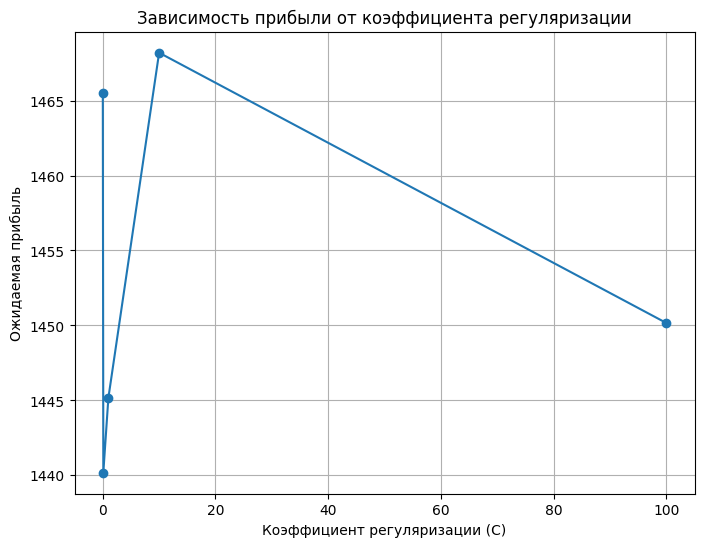

In [86]:
plt.figure(figsize=(8, 6))
plt.plot(C_values, profits, marker='o')
plt.xlabel("Коэффициент регуляризации (C)")
plt.ylabel("Ожидаемая прибыль")
plt.title("Зависимость прибыли от коэффициента регуляризации")
plt.grid(True)
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [89]:
from collections import Counter

num_repeats = 4
C_values = [5, 7, 10, 12, 15]
best_C_list = []

for repeat in range(num_repeats):
    best_C = None
    best_profit = -float("inf")

    for C in C_values:

        cv_results = cross_validate(X, y, C=C)
        mean_profit = cv_results['profit'].mean()
        if mean_profit > best_profit:
            best_profit = mean_profit
            best_C = C

    best_C_list.append(best_C)

best_C_counter = Counter(best_C_list)

print("\nЧастота выбора каждого C как лучшего:")
for C, count in best_C_counter.items():
    print(f"C = {C}: {count} раз")


Частота выбора каждого C как лучшего:
C = 7: 1 раз
C = 5: 3 раз



Коэффициент регуляризации C меняется между запусками, потому что прибыль формируется случайными числами, что добавляет вариативности в результаты. Это делает бизнес-метрику нестабильной, а выбор оптимального
C
C зависит от случайных колебаний в расчёте прибыли.

Когда я использовала более широкий диапазон значений
C
C (например,
[
0.01
,
0.1
,
1
,
10
,
100
]
[0.01,0.1,1,10,100]), выбор стабильно останавливался на одном значении, так как шаг между соседними коэффициентами был достаточно большим. В этом случае ближайший к оптимальному коэффициент становился единственным кандидатом. Но после того как я уменьшила шаг (например, при диапазоне
[
5
,
6
,
7
,
8
]
[5,6,7,8]), появилось больше возможных значений
C
C, близких к оптимуму, что вызвало разброс.

Разброс возник из-за того, что при более точной разметке небольшие случайные изменения в прибыли начинают сильнее влиять на выбор
C
C. В такой ситуации разница в прибыли между соседними значениями коэффициента становится минимальной, что делает выбор
C
C более чувствительным к случайным флуктуациям в данных.

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ В данной задаче для бизнеса важнее recall, так как основной целью является максимизация прибыли. Чем больше клиентов с высокой вероятностью согласия на депозит мы определим и позвоним, тем выше потенциальный доход. Потери из-за ложных определенний потенциальных клиентов (низкий precision) будут менее критичны, поскольку стоимость звонков относительно низкая, а пропуск потенциальных клиентов может обойтись дороже.



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [95]:
cv_results, profits_by_threshold = cross_validate(X, y, C=0.1)
cv_results

,accuracy,roc_auc,f1,auc_pr,profit,best_threshold
0,0.858097,0.780875,0.464989,0.429257,2732.066901,0.19
1,0.862102,0.800019,0.487365,0.466759,2925.189619,0.18
2,0.859553,0.780793,0.489634,0.449456,3237.691855,0.19
3,0.862814,0.803953,0.481175,0.451337,2904.338017,0.18
4,0.853830,0.791378,0.481034,0.455156,3127.566747,0.17


In [94]:
print(f"В среднем бизнес зарабатывает: {cv_results['profit'].mean()}.\n"
      f"Стандартное отклонение профита:{cv_results['profit'].std()}.\n"
      f"Лучший порог: {cv_results.loc[cv_results['profit'].idxmax(), 'best_threshold']}\n"
      f"Пропорциональна ли бизнес-метрика выбранной метрике классификации?:{cv_results['profit'].corr(cv_results['auc_pr']) > 0.45}.")

В среднем бизнес зарабатывает: 2966.314650764529.
Стандартное отклонение профита:161.5362874175459.
Лучший порог: 0.21
Пропорциональна ли бизнес-метрика выбранной метрике классификации?:True.


Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




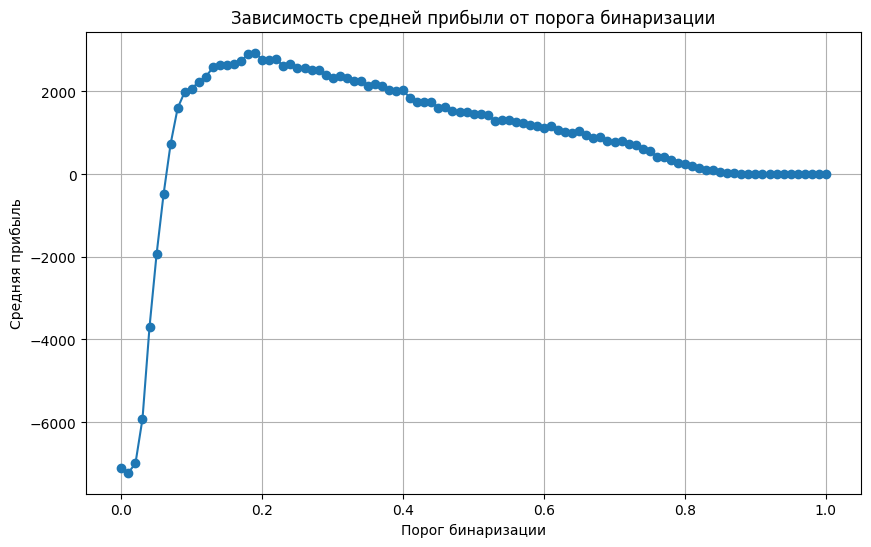

In [96]:
mean_profits = {threshold: np.mean(profits) for threshold, profits in profits_by_threshold.items()}

plt.figure(figsize=(10, 6))
plt.plot(mean_profits.keys(), mean_profits.values(), marker='o')
plt.xlabel("Порог бинаризации")
plt.ylabel("Средняя прибыль")
plt.title("Зависимость средней прибыли от порога бинаризации")
plt.grid(True)
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ График демонстрирует закономерность: прибыль сначала увеличивается с ростом порога бинаризации, достигает максимума в области 0.4–0.5, а затем постепенно снижается. Это связано с балансом между precision и recall — при низких порогах слишком много ложных срабатываний, при высоких порогах упускаются реальные положительные примеры. Порог оказывается в этой области, так как данные имеют стабильное распределение вероятностей, которое приводит к оптимальному значению именно здесь. При повторных запусках максимум остаётся примерно в той же области, что подтверждает эту закономерность.

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [97]:
# default
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

def cross_validate(#model,
    X,
    y,
    n_splits=5,
    random_state=42,
    shuffle=True,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = preprocessor.fit_transform(X_train)
        X_test = preprocessor.transform(X_test)

        model = LogisticRegression(max_iter=1000, random_state=random_state)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]



        calls_made = sum(y_pred == 1)
        successful_calls = sum((y_pred == 1) & (y_test == 1))
        #profit = (10 * successful_calls) - (2 * calls_made) - для первого варианта
        revenue = sum(np.random.uniform(0, 20, size=successful_calls))
        profit = revenue  - (2 * calls_made)



        metric_dict = {
            "accuracy": accuracy_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_pred_proba),
            "f1": f1_score(y_test, y_pred),
            "auc_pr": average_precision_score(y_test, y_pred_proba),
            "profit": profit,
            "calls_made": calls_made
        }

        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

In [100]:
from scipy.stats import ttest_rel
cv_results_default = cross_validate(X, y)

opt_model_mean_profit = cv_results_default['profit'].mean()
opt_model_std_profit = cv_results_default['profit'].std()

ord_model_mean_profit = cv_results_default['profit'].mean()
ord_model_std_profit = cv_results_default['profit'].std()

print(f"Средняя прибыль для дефолтной модели: {ord_model_mean_profit}")
print(f"Стандартное отклонение для дефолтной модели: {ord_model_std_profit}")
print(f"Средняя прибыль для оптимизированной модели: {opt_model_mean_profit}")
print(f"Стандартное отклонение для оптимизированной модели: {opt_model_std_profit}")

t_stat, p_value = ttest_rel(cv_results['profit'], cv_results_default['profit'])
print(f"t-статистика: {t_stat}")
print(f"p-значение: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Разница в прибыли между моделями статистически значима (отклоняем H0).")
else:
    print("Разница в прибыли между моделями незначима (не отклоняем H0).")

Средняя прибыль для дефолтной модели: 1479.829725018856
Стандартное отклонение для дефолтной модели: 149.78371101468588
Средняя прибыль для оптимизированной модели: 1479.829725018856
Стандартное отклонение для оптимизированной модели: 149.78371101468588
t-статистика: 33.762503947940594
p-значение: 4.590679545144291e-06
Разница в прибыли между моделями статистически значима (отклоняем H0).


# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [1]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

100%|██████████| 87.2k/87.2k [00:00<00:00, 19.6MB/s]

Extracting files...


In [4]:
data = pd.read_csv(path)
X = data[features]
y = data[target]

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [6]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

numeric = X.select_dtypes(include=['float', 'int']).columns.tolist()
binary = [col for col in numeric if X[col].nunique() == 2]
numeric = [col for col in numeric if col not in binary]
categorical = X.select_dtypes(include=['object']).columns.tolist()


numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler(with_mean=False))
])



binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric),
        ('cat', categorical_transformer, categorical),
        ('binary', binary_transformer, binary)
    ]
)
X = preprocessor.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [12]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

start_time_ovr = time.time()
ovr_model = OneVsRestClassifier(LogisticRegression(max_iter=10000)).fit(X_train, y_train)
selection_time_ovr = time.time() - start_time_ovr

start_time_ovo = time.time()
ovo_model = OneVsOneClassifier(LogisticRegression(max_iter=10000)).fit(X_train, y_train)
selection_time_ovo= time.time() - start_time_ovo

pred_ovr = ovr_model.predict(X_test)
pred_ovo = ovo_model.predict(X_test)

f1_ovr = f1_score(y_test, pred_ovr, average="weighted")
f1_ovo = f1_score(y_test, pred_ovo, average="weighted")

num_class_ovr = len(ovr_model.estimators_)
num_class_ovo = len(ovo_model.estimators_)

results = pd.DataFrame({
    "Метрика": ["Число классификаторов", "Скорость обучения", "F1"],
    "One-vs-Rest": [num_class_ovr, selection_time_ovr, f1_ovr],
    "One-vs-One": [num_class_ovo, selection_time_ovo, f1_ovo]
})
results

,Метрика,One-vs-Rest,One-vs-One
0,Число классификаторов,3.000000,3.000000
1,Скорость обучения,0.105566,0.080548
2,F1,0.489435,0.488627


Как вы объясните полученные результаты?

__Ответ:__ Объяснение выбора метрики: В задаче важно как не упускать студентов, которые могут не доучиться (высокий recall), так и не ошибаться в определении тех, кто доучится (высокий precision). F1 помогает учитывать баланс между precision и recall.

Результаты по метрике, числу классификаторов и времени обучения можно объяснить так: у нас наблюдается значительный дисбаланс классов, где доминирует класс 2, а класс 1 представлен в наименьшем количестве. Это приводит к тому, что обе стратегии — One-vs-Rest и One-vs-One — концентрируются на разделении более распространённых классов, что делает их качество (F1 меру) почти одинаковым. Число классификаторов совпадает, так как каждая из стратегий работает с 3 классами, хотя в нормальной ситуации OvO создаёт больше классификаторов. Время обучения для OvO оказалось немного быстрее, вероятно, из-за меньшего объёма данных, используемых для обучения каждой пары классов. Итоговая разница между стратегиями минимальна из-за структуры данных и доминирования одного класса.


#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [19]:
from typing import Iterable, Optional
from torch.nn.functional import softmax, cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    n_objects, n_classes = y_pred.shape
    y_true_one_hot = np.zeros((n_objects, n_classes))
    y_true_one_hot[np.arange(n_objects), y_true] = 1

    exp_logits = np.exp(y_pred)
    softmax_probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    log_probs = np.log(softmax_probs + 1e-15)
    ce_loss = -np.mean(np.sum(y_true_one_hot * log_probs, axis=1))
    return ce_loss

In [20]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [27]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    logits = X @ W

    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    n_objects, n_classes = logits.shape
    y_one_hot = np.zeros((n_objects, n_classes))
    y_one_hot[np.arange(n_objects), y] = 1

    diff = probs - y_one_hot
    grad = X.T @ diff/ n_objects

    return grad

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [35]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def custom_ce(self, y_pred, y_true):
        n_objects, n_classes = y_pred.shape
        y_true_one_hot = np.zeros((n_objects, n_classes))
        y_true_one_hot[np.arange(n_objects), y_true] = 1

        exp_logits = np.exp(y_pred)
        softmax_probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

        log_probs = np.log(softmax_probs + 1e-15)
        ce_loss = -np.mean(np.sum(y_true_one_hot * log_probs, axis=1))
        return ce_los

    def ce_gradient(self, X, W, y):
        logits = X @ W

        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

        n_objects, n_classes = logits.shape
        y_one_hot = np.zeros((n_objects, n_classes))
        y_one_hot[np.arange(n_objects), y] = 1

        diff = probs - y_one_hot
        grad = X.T @ diff / n_objects

        return grad

    def fit(self, X, y):
        n_objects, n_features = X.shape
        n_classes = np.unique(y).shape[0]

        self.W = np.random.randn(n_features, n_classes)

        for i in range(self.max_iter):
            grad = self.ce_gradient(X, self.W, y)
            self.W -= self.lr * grad

    def predict(self, X, y=None):
        logits = X @ self.W
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return np.argmax(probs, axis=1)

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [36]:
start_time_softmax = time.time()
softmax_model = SoftmaxRegression(lr=1e-2, max_iter=5000)
softmax_model.fit(X_train, y_train)
selection_time_softmax = time.time() - start_time_softmax

pred_softmax = softmax_model.predict(X_test)

f1_softmax = f1_score(y_test, pred_softmax, average="weighted")

num_class_softmax = len(np.unique(y_train))


results = pd.DataFrame({
    "Метрика": ["Число классификаторов", "Скорость обучения", "F1"],
    "One-vs-Rest": [num_class_ovr, selection_time_ovr, f1_ovr],
    "One-vs-One": [num_class_ovo, selection_time_ovo, f1_ovo],
    "Softmax": [num_class_softmax, selection_time_softmax, f1_softmax]
})

results

,Метрика,One-vs-Rest,One-vs-One,Softmax
0,Число классификаторов,3.000000,3.000000,3.000000
1,Скорость обучения,0.105566,0.080548,5.937803
2,F1,0.489435,0.488627,0.469153


__Ответ__: Судя по результатам, все три модели работают с одинаковым числом классификаторов, что ожидаемо, поскольку задача мультиклассовая, и все подходы используют 3 класса. Однако скорость обучения у моделей различается: Softmax оказался самым медленным (около 6 секунд), что связано с оптимизацией всей функции потерь за счёт матричных операций. One-vs-One, напротив, обучается быстрее всех (0.08 секунд), поскольку обучает отдельные бинарные классификаторы, а One-vs-Rest занимает промежуточное положение. По F1-метрике One-vs-Rest показывает немного лучшее качество (0.489), чем One-vs-One (0.488), а Softmax здесь уступает с результатом 0.469.

С учётом задачи, где важна комбинация скорости и качества, лучше остановиться на One-vs-Rest. Оно даёт чуть лучшее качество классификации, чем One-vs-One, при этом оставаясь достаточно быстрым.

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ Кофе, потому что нужно было успеть доделать дз и сдать отчет по работе. Я надеюсь, что я не умру, когда-нибудь от язвы желудка((((